In [24]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
adata = sc.read_h5ad('QCed_GSE184290.h5ad')

In [4]:
#makesure I'm in celltypist_stable_env: python=3.9 numba=0.58.1 numpy=1.26.4 - install celltypist + decoupler first, then scanpy
import celltypist as ct
import decoupler as dc

In [5]:
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res2", resolution=2)

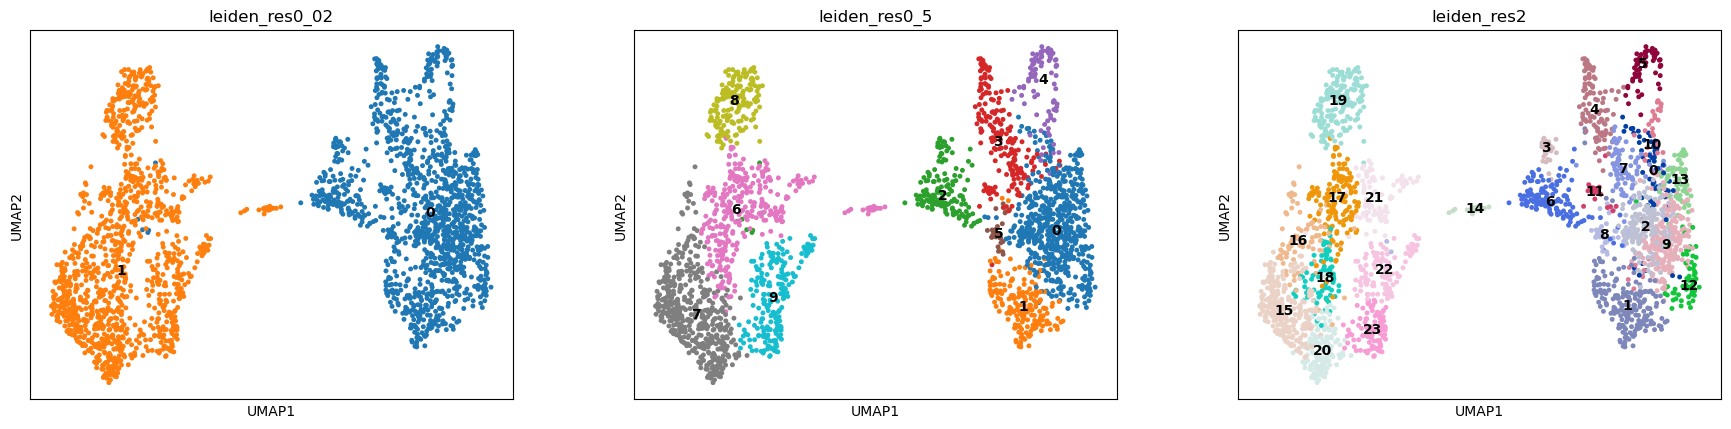

In [6]:
sc.pl.umap(
    adata,
    color=["leiden_res0_02", "leiden_res0_5", "leiden_res2"],
    legend_loc="on data",
)

UMAPs should not be over-interpreted, here we can already see that in the highest resolution our data is over-clustered, while the lowest resolution is likely grouping cells of the two cell identities (interstital macrophage and alveolar macrophage). The middle resolution of 0.5 appears to be a suitable middle-ground with plausably distinct clusters.

### Cluster Validation
Plot the clusters as a dotplot to validate the top genes represenet seperate clusters well

In [22]:
#at this point, there are as many clusters as the resolution calcualtioned
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', key_added='ranked_genes') # Or 'louvain' / 'logreg', 't-test' - one vs all tests to find "most exemplary/cluster"
top_n_genes_to_plot = 5 
marker_genes_dict = {}

cluster_names = adata.obs['leiden'].cat.categories
for cluster in cluster_names:
        genes_for_this_cluster = adata.uns['ranked_genes']['names'][cluster].tolist()[:top_n_genes_to_plot]
        genes_for_this_cluster = [gene for gene in genes_for_this_cluster if pd.notna(gene)]

        if genes_for_this_cluster: # Only add if there are actual genes
            marker_genes_dict[cluster] = genes_for_this_cluster
        else:
            print(f"  Warning: No marker genes found for cluster {cluster} after selecting top {top_n_genes_to_plot}.")
print(f"\nExtracted top {top_n_genes_to_plot} marker genes for each of {len(cluster_names)} clusters.")
print(f"Clusters with extracted markers: {list(marker_genes_dict.keys())}")
print(f"cluster confirmation: {adata.obs['leiden'].value_counts()}")



Extracted top 5 marker genes for each of 11 clusters.
Clusters with extracted markers: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
cluster confirmation: leiden
0     586
1     466
2     309
3     208
4     186
5     180
6     172
7     169
8      76
9      27
10     20
Name: count, dtype: int64


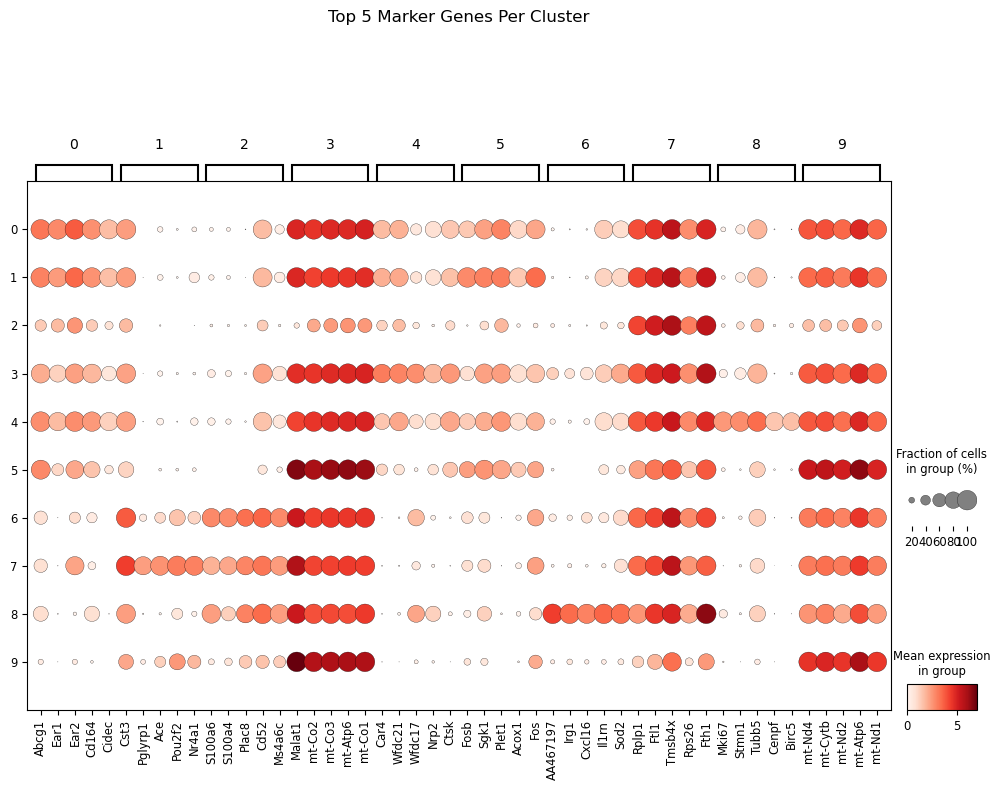


Dot plot generated with simplified parameters.


In [29]:
# --- Simplified Dot Plot Code ---
# It's still good practice to explicitly create a figure and axes for better control,
# even if you set a very basic figsize.

fig, ax = plt.subplots(figsize=(10, 8)) # Basic figure size, adjust as needed

sc.pl.dotplot(
    adata,
    var_names=marker_genes_dict, # Pass the dictionary containing genes for each cluster
    groupby='leiden_res0_5',   # Your cluster column name
    ax=ax,                      # Plot onto the created axes
    title=f'Top {top_n_genes_to_plot} Marker Genes Per Cluster',
    show=False                  # Always set to False if using plt.show()
)

plt.tight_layout()
plt.show()

print("\nDot plot generated with simplified parameters.")

### Gene Set Enrichment with Gprofiler
#### Get Your Gene List(s)
Before you go to gProfiler, you need the gene lists you want to analyze. In single-cell RNA-seq, these commonly come from:

1. Marker Genes per Cluster: Genes that are highly expressed or differentially expressed in a specific cell cluster (e.g., genes defining your AM or IM clusters, or sub-clusters within them). 
Differentially Expressed Genes (DEGs) per Condition: Genes that are significantly up- or down-regulated between two conditions (e.g., AM_KP+ vs AM_Control).

In [30]:
#pip install gprofiler-official
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)

# Set your organism. Use the short ID (e.g., 'mmusculus' for mouse, 'hsapiens' for human).
organism_id = 'mmusculus' # Adjust based on your data

# Define your custom background genes (all genes present in your adata object after QC)
background_genes = adata.var_names.tolist()

In [31]:
all_enrichment_results_df = []

for cluster_name, genes_list in all_cluster_marker_genes.items():
    print(f"\n--- Running enrichment for {cluster_name} with {len(genes_list)} genes ---")
    if not genes_list: # Double-check to ensure gene list isn't empty
        print(f"  {cluster_name} has no genes, skipping.")
        continue

    try:
        results = gp.profile(
            organism=organism_id,
            query=genes_list,
            sources=['GO:BP', 'KEGG', 'REAC'], # Example sources. You can add or remove.
            background=background_genes,
            user_threshold=0.05, # Adjusted p-value threshold
            # numeric_ns=True # Add if you want numeric IDs for GO terms
        )

        if not results.empty:
            results['cluster'] = cluster_name # Add cluster name to results
            all_enrichment_results_df.append(results)
            print(f"  Found {len(results)} significant terms for {cluster_name}.")
        else:
            print(f"  No significant terms found for {cluster_name} at p < 0.05.")

    except Exception as e:
        print(f"  An error occurred during enrichment for {cluster_name}: {e}")

# Combine all results into a single DataFrame
if all_enrichment_results_df:
    final_enrichment_df = pd.concat(all_enrichment_results_df, ignore_index=True)
    print("\n--- Combined Enrichment Results (first 10 rows) ---")
    print(final_enrichment_df.head(10))

    # You can save this DataFrame
    final_enrichment_df.to_csv("gprofiler_all_cluster_enrichment.csv", index=False)
    print("\nFull enrichment results saved to gprofiler_all_cluster_enrichment.csv")
else:
    print("\nNo enrichment results were generated for any cluster.")


--- Running enrichment for cluster_0 with 100 genes ---
  Found 14 significant terms for cluster_0.

--- Running enrichment for cluster_1 with 100 genes ---
  Found 155 significant terms for cluster_1.

--- Running enrichment for cluster_2 with 100 genes ---
  Found 94 significant terms for cluster_2.

--- Running enrichment for cluster_3 with 100 genes ---
  Found 45 significant terms for cluster_3.

--- Running enrichment for cluster_4 with 100 genes ---
  Found 42 significant terms for cluster_4.

--- Running enrichment for cluster_5 with 100 genes ---
  Found 8 significant terms for cluster_5.

--- Running enrichment for cluster_6 with 100 genes ---
  Found 188 significant terms for cluster_6.

--- Running enrichment for cluster_7 with 100 genes ---
  Found 46 significant terms for cluster_7.

--- Running enrichment for cluster_8 with 100 genes ---
  Found 184 significant terms for cluster_8.

--- Running enrichment for cluster_9 with 100 genes ---
  Found 37 significant terms for